In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, GRU

In [2]:
# Load data
df = pd.read_csv('../Dataset/DP3 Historical Data.csv', parse_dates=['Date'])
df1 = df1=df.reset_index()['Price']
df1

0       68,000
1       68,000
2       68,500
3       69,300
4       68,900
         ...  
1141    91,800
1142    87,900
1143    87,900
1144    86,500
1145    85,500
Name: Price, Length: 1146, dtype: object

In [3]:
df1 = df1.str.replace(',', '').astype(float)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\khaqt\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.1401 - val_loss: 0.0175
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0165 - val_loss: 0.0406
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0124 - val_loss: 0.0130
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0093 - val_loss: 0.0120
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0058 - val_loss: 0.0110
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - loss: 0.0051 - val_loss: 0.0015
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0028 - val_loss: 8.0700e-04
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0025 - val_loss: 4.9363e-04
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0041 - val_loss: 3.6778e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 84010.77182737555
Testing RMSE: 66891.84812707621


In [20]:
x_input = val_data[-60:].reshape((1, -1))
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) >= 100:  # Ensure at least 100 time steps for input
        x_input = np.array(temp_input[-100:])  # Take the last 100 elements
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1, 1)  # Reshape to match model input shape
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = np.array(temp_input)  # Use all available data if less than 100 time steps
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i = i + 1

[0.28942686]
61
[0.2914343]
62
[0.29487288]
63
[0.298991]
64
[0.30346566]
65
[0.30814055]
66
[0.3129333]
67
[0.3177971]
68
[0.3227033]
69
[0.32763284]
70
[0.33257216]
71
[0.33751133]
72
[0.34244287]
73
[0.34736052]
74
[0.35225922]
75
[0.3571347]
76
[0.36198306]
77
[0.36680114]
78
[0.3715859]
79
[0.37633452]
80
[0.38104466]
81
[0.38571373]
82
[0.39033976]
83
[0.39492065]
84
[0.3994543]
85
[0.40393895]
86
[0.4083729]
87
[0.41275445]
88
[0.41708213]
89
[0.42135432]
90


In [19]:
# # 13. Dự báo 30 ngày tiếp theo
# x_input = val_data[-60:].reshape((1, -1))
# x_input.shape

# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# while(i<30):
#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1

ValueError: cannot reshape array of size 60 into shape (1,100,1)

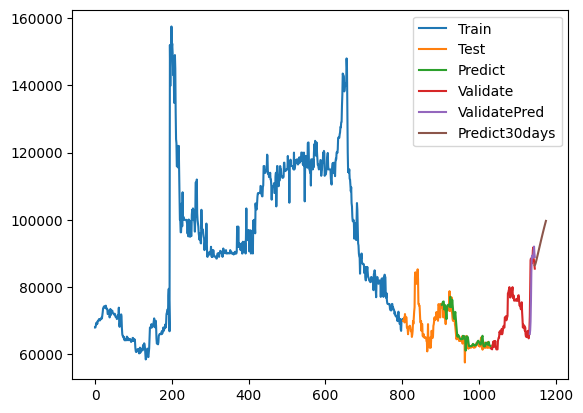

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()